# IT550 Information Retrieval Assignment-4
## Student ID - 202011032

## Importing necessary libraries

In [1]:
!pip install edlib
import edlib
import json
import numpy as np
import pandas as pd

     |████████████████████████████████| 307kB 5.4MB/s 


## Creating classes for string distance measuring and YASS stemmer

In [2]:
class DistanceMeasure:
    '''Implements string distance measures as given in YASS stemmer paper'''
    def __init__(self):
        self._sum_1to30 = np.sum(np.fromiter((1 / (2 ** i) for i in range(0, 30)), np.float16))

    def _penalty(self, s1, s2, for_d1=False):
        s1, s2 = s1.lower(), s2.lower()
        # Pad the shorter string with null character(here * is null char)
        if len(s1) < len(s2):
            s1 = s1.ljust(len(s2), '*')
        elif len(s1) > len(s2):
            s2 = s2.ljust(len(s1), '*')
        
        if for_d1:
            p = []
            for i, j in zip(s1, s2):
                if i != j: p.append(1)
                else: p.append(0)
            p = np.array(p)
            return np.where(p == 1)[0]
        else:
            for idx, (i, j) in enumerate(zip(s1, s2)):
                if i != j:
                    # Return index of first mismatch
                    return idx
            return 0

    def d1(self, s1: str, s2: str):
        '''Returns D1 distance between two strings.'''
        idxs = self._penalty(s1, s2, for_d1=True)
        return np.sum(np.fromiter((1 / (2 ** i) for i in idxs), np.float16))
    
    def d2(self, s1: str, s2: str):
        '''Returns D2 distance between two strings.'''
        m = self._penalty(s1, s2)
        if m <= 0: return np.inf

        n_plus_1 = max(len(s1), len(s2))
        diff = n_plus_1 - m
        sub = np.sum(np.fromiter((1 / (2 ** i) for i in range(diff, 30)), np.float16))
        return 1/m * (self._sum_1to30 - sub)
    
    def d3(self, s1: str, s2: str):
        '''Returns D3 distance between two strings.'''
        m = self._penalty(s1, s2)
        if m <= 0: return np.inf

        n_plus_1 = max(len(s1), len(s2))
        diff = n_plus_1 - m
        sub = np.sum(np.fromiter((1 / (2 ** i) for i in range(diff, 30)), np.float16))
        return (n_plus_1 - m) / m * (self._sum_1to30 - sub)
    
    def d4(self, s1: str, s2: str):
        '''Returns D4 distance between two strings.'''
        m =self._penalty(s1, s2)

        n_plus_1 = max(len(s1), len(s2))
        diff = n_plus_1 - m
        sub = np.sum(np.fromiter((1 / (2 ** i) for i in range(diff, 30)), np.float16))
        return (n_plus_1 - m) / n_plus_1 * (self._sum_1to30 - sub)
    
    def levenshtein_dist(self, s1: str, s2: str):
        '''Return Levenshtein distance between two strings.'''
        return edlib.align(s1, s2, task='distance')['editDistance']


In [3]:
PATH = "stemming-assignment.txt"

In [5]:
with open(PATH) as words_file:
    words = np.array([word.strip() for word in words_file.readlines()])
words

array(['a', 'aaron', 'abaissiez', ..., 'zone', 'zounds', 'zwagger'],
      dtype='<U27')

## Create distance matrices using the DistanceMeasure class for corpus of words

Creating input of indexes of words list for passing to the `pairwise_distances` function

In [ ]:
from sklearn.metrics import pairwise_distances

X = np.searchsorted(words, words.reshape(-1, 1))
print(X.shape)

(23531, 1)


Defining integrating functions for calculating distance measures for `pairwise_distances`

In [ ]:
dist_m = DistanceMeasure()

def test_d1(x, y):
    return dist_m.d1(words[int(x[0])], words[int(y[0])])

def test_d2(x, y):
    return dist_m.d2(words[int(x[0])], words[int(y[0])])

def test_d3(x, y):
    return dist_m.d3(words[int(x[0])], words[int(y[0])])

def test_d4(x, y):
    return dist_m.d4(words[int(x[0])], words[int(y[0])]).astype(np.float16)

Generating $D_4$ distance matrix for words list

In [ ]:
d_mat = pairwise_distances(X, metric=test_d4, n_jobs=-1, force_all_finite=False)
print(d_mat)
np.save('/content/drive/MyDrive/IR_Assignment4/d4_mat.npy', d_mat)
del d_mat

[[1.         1.5        1.77050781 ... 1.875      1.96875    1.984375  ]
 [1.5        1.9375     1.77050781 ... 1.9375     1.96875    1.984375  ]
 [1.77050781 1.77050781 1.99609375 ... 1.99609375 1.99609375 1.99609375]
 ...
 [1.875      1.9375     1.99609375 ... 1.875      1.25       1.6875    ]
 [1.96875    1.96875    1.99609375 ... 1.25       1.96875    1.6875    ]
 [1.984375   1.984375   1.99609375 ... 1.6875     1.6875     1.984375  ]]


Generating $D_3$ distance matrix for words list

In [ ]:
d_mat = pairwise_distances(X, metric=test_d3, n_jobs=-1, force_all_finite=False)
print(d_mat)
np.save('/content/drive/MyDrive/IR_Assignment4/d3_mat.npy', d_mat)
del d_mat

[[    inf  7.5    15.9375 ...     inf     inf     inf]
 [ 7.5        inf 15.9375 ...     inf     inf     inf]
 [15.9375 15.9375     inf ...     inf     inf     inf]
 ...
 [    inf     inf     inf ...     inf  3.75   11.8125]
 [    inf     inf     inf ...  3.75       inf 11.8125]
 [    inf     inf     inf ... 11.8125 11.8125     inf]]


Generating $D_2$ distance matrix for words list

In [ ]:
d_mat = pairwise_distances(X, metric=test_d2, n_jobs=-1, force_all_finite=False)
print(d_mat)
np.save('/content/drive/MyDrive/IR_Assignment4/d2_mat.npy', d_mat)
del d_mat

[[      inf 1.875     1.9921875 ...       inf       inf       inf]
 [1.875           inf 1.9921875 ...       inf       inf       inf]
 [1.9921875 1.9921875       inf ...       inf       inf       inf]
 ...
 [      inf       inf       inf ...       inf 0.9375    1.96875  ]
 [      inf       inf       inf ... 0.9375          inf 1.96875  ]
 [      inf       inf       inf ... 1.96875   1.96875         inf]]


Generating $D_1$ distance matrix for words list

In [ ]:
d_mat = pairwise_distances(X, metric=test_d1, n_jobs=-1, force_all_finite=False)
print(d_mat)
np.save('/content/drive/MyDrive/IR_Assignment4/d1_mat.npy', d_mat)
del d_mat

[[0.         0.9375     0.99609375 ... 1.875      1.96875    1.984375  ]
 [0.9375     0.         0.99609375 ... 1.9375     1.96875    1.984375  ]
 [0.99609375 0.99609375 0.         ... 1.99609375 1.96484375 1.74609375]
 ...
 [1.875      1.9375     1.99609375 ... 0.         0.46875    0.984375  ]
 [1.96875    1.96875    1.96484375 ... 0.46875    0.         0.984375  ]
 [1.984375   1.984375   1.74609375 ... 0.984375   0.984375   0.        ]]


## Perform agglomerative clustering for the $D_1, D_2, D_3,$ and $D_4$ distance matrices and make a graph of no. of clusters formed v/s distance threshold

Importing necessary libraries

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

Loading $D_1$ distance matrix and performing clustering and generating graph

In [ ]:
d1_mat = np.load("/content/drive/MyDrive/IR_Assignment4/d1_mat.npy", mmap_mode='r')

In [ ]:
print(d1_mat)

[[0.         0.9375     0.99609375 ... 1.875      1.96875    1.984375  ]
 [0.9375     0.         0.99609375 ... 1.9375     1.96875    1.984375  ]
 [0.99609375 0.99609375 0.         ... 1.99609375 1.96484375 1.74609375]
 ...
 [1.875      1.9375     1.99609375 ... 0.         0.46875    0.984375  ]
 [1.96875    1.96875    1.96484375 ... 0.46875    0.         0.984375  ]
 [1.984375   1.984375   1.74609375 ... 0.984375   0.984375   0.        ]]


In [ ]:
d1_clusters = []
for d in np.arange(0.00, 0.50, 0.05):
    cluster_d1 = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                        linkage='single', distance_threshold=d)
    cluster_labels = cluster_d1.fit_predict(d1_mat)
    d1_clusters.append(cluster_d1.n_clusters_)
    print(cluster_d1.n_clusters_)
    print(cluster_labels)


23531
[19263 18495 12755 ...     4     1     0]
14150
[ 9631  9247 12755 ... 10738  5073  4099]
9100
[4815 4623 6377 ... 2683 2536 4099]
5144
[4815 4623 3188 ... 2683 2536 4099]
3379
[2407 2311 3188 ... 2683 2536 2049]
2205
[1203 1155  548 ... 1341 1267 2049]
869
[601 577  73 ... 670 633 255]
639
[601 577 296 ... 334 633 255]
434
[300 288 296 ...  18 316 255]
342
[300 288 296 ...  38 316 255]


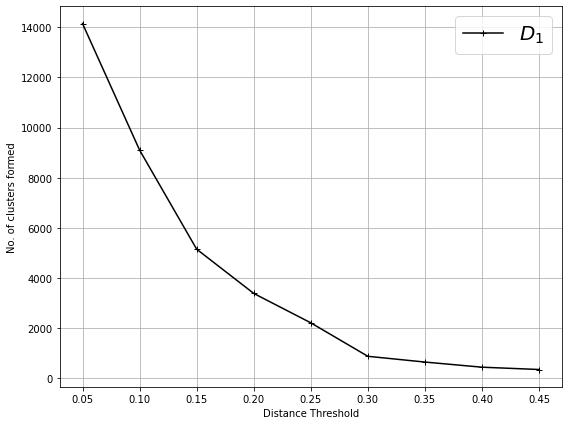

In [ ]:
plt.rcParams["figure.figsize"] = (9,7)
plt.plot(np.arange(0.05, 0.50, 0.05), d1_clusters[1:], 'k+-', label="$D_1$")
plt.xlabel('Distance Threshold')
plt.ylabel('No. of clusters formed')
ax = plt.gca()
ax.set_xticks(np.arange(0.05, 0.50, 0.05))
ax.set_yticks(np.arange(0, 15000, 2000))
plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()

Loading $D_2$ distance matrix and performing clustering and generating graph

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


23407
[19455 15103 14983 ...    22  1889   123]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


19794
[19455 15103 14983 ...  1534  7560  3975]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


14298
[9727 7551 7491 ... 6140 7560 7951]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


8398
[4863 7551 7491 ... 3069 7560 7951]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


5747
[4863 3775 3745 ... 1534 1889 3975]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2877
[2431 1887 1872 ... 1534  944 1987]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1628
[1215  943  237 ... 1534  944  993]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


991
[607 943 476 ...   0 944 496]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


687
[607 471  43 ... 184 235 496]


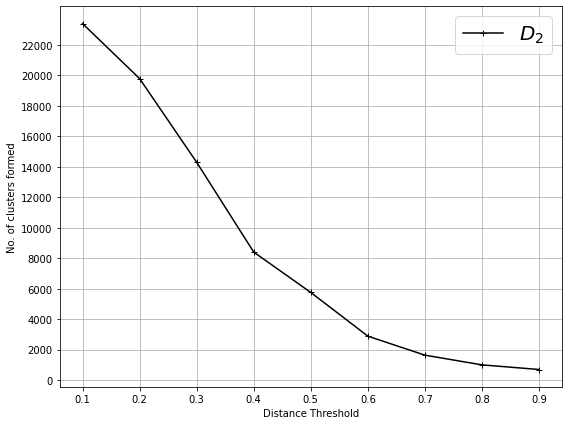

In [ ]:
d2_mat = np.load("/content/drive/MyDrive/IR_Assignment4/d2_mat.npy", mmap_mode='r')
d2_clusters = []
for d in np.arange(0.10, 1.00, 0.10):
    cluster_d2 = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                        linkage='single', distance_threshold=d)
    cluster_labels = cluster_d2.fit_predict(np.nan_to_num(d2_mat))
    d2_clusters.append(cluster_d2.n_clusters_)
    print(cluster_d2.n_clusters_)
    print(cluster_labels)

plt.rcParams["figure.figsize"] = (9,7)
plt.plot(np.arange(0.10, 1.00, 0.10), d2_clusters, 'k+-', label="$D_2$")
plt.xlabel('Distance Threshold')
plt.ylabel('No. of clusters formed')
ax = plt.gca()
ax.set_xticks(np.arange(0.10, 1.00, 0.10))
ax.set_yticks(np.arange(0, 23000, 2000))
plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()

Loading $D_3$ distance matrix and performing clustering and generating graph

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


19180
[10257  9855 18175 ...  3149  4566  2185]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


15304
[10257  9855  9087 ...  3149  4566  2185]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


12759
[10257  9855  9087 ...  6300  9133  4372]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


10258
[10257  9855  9087 ...  3150  9133  4372]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


7847
[ 835 4927 4543 ... 3150 4566 2185]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


6231
[1556 4927 4543 ...  786 4566 2185]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


4989
[ 202 4927 4543 ...  597 4566 2185]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2877
[  62 2463 2271 ...  598 1140 1092]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2877
[  62 2463 2271 ...  598 1140 1092]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2452
[ 219 1231 2271 ... 1197 1140 1092]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1466
[   0 1231 1135 ...  598  284 1092]


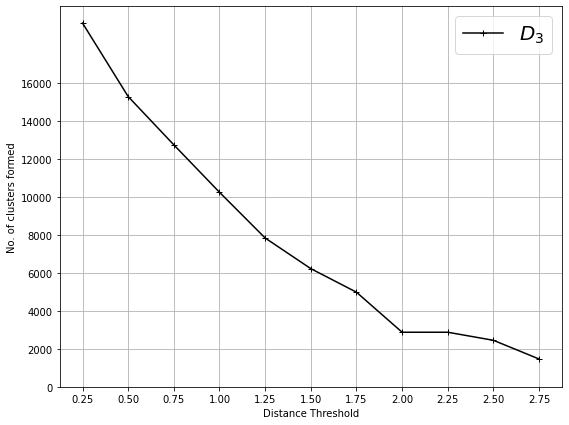

In [ ]:
d3_mat = np.load("/content/drive/MyDrive/IR_Assignment4/d3_mat.npy", mmap_mode='r')
d3_clusters = []
for d in np.arange(0.25, 3.00, 0.25):
    cluster_d3 = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                        linkage='single', distance_threshold=d)
    cluster_labels = cluster_d3.fit_predict(np.nan_to_num(d3_mat))
    d3_clusters.append(cluster_d3.n_clusters_)
    print(cluster_d3.n_clusters_)
    print(cluster_labels)

plt.rcParams["figure.figsize"] = (9,7)
plt.plot(np.arange(0.25, 3.00, 0.25), d3_clusters, 'k+-', label="$D_3$")
plt.xlabel('Distance Threshold')
plt.ylabel('No. of clusters formed')
ax = plt.gca()
ax.set_xticks(np.arange(0.25, 3.00, 0.25))
ax.set_yticks(np.arange(0, 17000, 2000))
plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()

Loading $D_4$ distance matrix and performing clustering and generating graph

17667
[12763  9727 17503 ...  2014 10194 11416]
17632
[12763  9727 17503 ...  2014 10194 11416]
16073
[12763  9727  8751 ...  2014 10194 11416]
14735
[12763  9727  8751 ...  2014 10194 11416]
14013
[12763  9727  8751 ...  2014 10194 11416]
12944
[12763  9727  8751 ...  2014 10194 11416]
12764
[12763  9727  8751 ...  2014 10194 11416]
10870
[ 1435  9727  8751 ...  2014 10194  5707]
10198
[ 1435  9727  8751 ...  2014 10194  5707]
8960
[ 315 4863 8751 ... 2014 5096 5707]
7855
[ 699 4863 4375 ... 2014 5096 5707]
7847
[ 699 4863 4375 ... 2014 5096 5707]
5637
[2834 4863 4375 ...    4 5096 2853]
5110
[ 159 4863 4375 ...  691 5096 2853]
3878
[  60 2431 2187 ... 1384 1273 2853]
3144
[ 224 2431 2187 ... 1384 1273 2853]
2877
[  47 2431 2187 ... 1384 1273 2853]


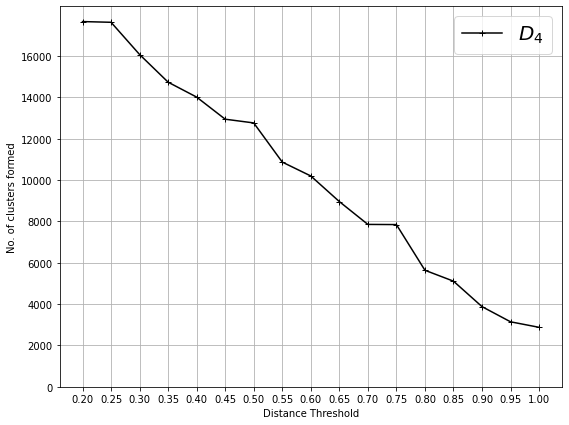

In [ ]:
d4_mat = np.load("/content/drive/MyDrive/IR_Assignment4/d4_mat.npy", mmap_mode='r')
d4_clusters = []
d4_cluster_labels_per_threshold = []
for d in np.arange(0.20, 1.05, 0.05):
    cluster_d4 = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                        linkage='single', distance_threshold=d)
    cluster_labels = cluster_d4.fit_predict(d4_mat)
    d4_clusters.append(cluster_d4.n_clusters_)
    d4_cluster_labels_per_threshold.append(cluster_labels)

    print(cluster_d4.n_clusters_)
    print(cluster_labels)

plt.rcParams["figure.figsize"] = (9,7)
plt.plot(np.arange(0.20, 1.05, 0.05), d4_clusters, 'k+-', label="$D_4$")
plt.xlabel('Distance Threshold')
plt.ylabel('No. of clusters formed')
ax = plt.gca()
ax.set_xticks(np.arange(0.20, 1.05, 0.05))
ax.set_yticks(np.arange(0, 17000, 2000))
plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()

Saving $D_4$ clusters and their corresponding distance thresholds

In [ ]:
import json
with open('/content/drive/MyDrive/IR_Assignment4/d4_clusters.json', 'w') as d4_file:
    d4_file.write(json.dumps({
        'd': np.arange(0.20, 1.05, 0.05).tolist(),
        'n_clusters': d4_clusters,
        'cluster_labels': [labels.tolist() for labels in d4_cluster_labels_per_threshold]
        }, indent=2))

## Implementing YASS Stemmer with $D_4$ as distance metric as 0.85 as distance threshold for clustering

Creating a mapping dictionary of words mapped to their root words. Root words are considered if they are more than 2 characters long. Clusters formed from $D_4$ distance metric with a distance threshold of $0.85$ is used. $5110$ clusters are formed.

In [49]:
import json

with open('/content/drive/MyDrive/IR_Assignment4/d4_clusters.json', 'r') as d4_file:
    d4_clust_dict = json.loads(d4_file.read())
    d_thresh = d4_clust_dict['d'][13]
    n_clusters = d4_clust_dict['n_clusters'][13]
    c_labels = d4_clust_dict['cluster_labels'][13]

print(f"Distance Threshold: {d_thresh: 0.3}, Clusters formed: {n_clusters}")
# cluster_mapping = {word: label for word, label in zip(words, c_labels)}

label_clusters = {}
for word, label in zip(words, c_labels):
    if len(word) > 2:
        label_clusters[label] = label_clusters.get(label, []) + [word]

root_word_per_label = {label: min(words_per_label, key=len) for label, words_per_label in label_clusters.items()}
cluster_mapping = {
    word: root_word_per_label[label] for word, label in zip(words, c_labels) if len(word) > 2
}
print(label_clusters)
print(root_word_per_label)
print(cluster_mapping)

Distance Threshold:  0.85, Clusters formed: 5110
{4863: ['aaron'], 4375: ['abaissiez'], 2454: ['abandon', 'abandoned'], 345: ['abase', 'abash', 'abate', 'abated', 'abatement', 'abatements', 'abates'], 1383: ['abbess', 'abbey', 'abbeys', 'abbot', 'abbots'], 5079: ['abbominable'], 2671: ['abbreviated'], 215: ['abed', 'abel', 'abet', 'able', 'abler', 'abr', 'abraham', 'abram', 'abus', 'abuse', 'abused', 'abuser', 'abuses', 'abusing', 'aby', 'abysm'], 5075: ['aberga'], 3989: ['abergavenny'], 3856: ['abetting'], 5071: ['abhominable'], 690: ['abhor', 'abhorr', 'abhorred', 'abhorring', 'abhors', 'abhorson'], 1382: ['abide', 'abides'], 2448: ['abilities', 'ability'], 2798: ['abject', 'abjectly', 'abjects'], 2154: ['abjur', 'abjure'], 4309: ['aboard'], 1395: ['abode', 'aboded', 'aboding', 'abound', 'abounding', 'about', 'above'], 3026: ['abodements'], 229: ['abominable', 'abominably', 'abominations'], 4706: ['abortive', 'abortives'], 4899: ['abreast'], 1267: ['abridg', 'abridge', 'abridged', 'a

### Creating a class for *YASS Stemmer*
In the `__init__(self)` constructor a `DistanceMeasure` object alongside a dictionary of words as keys and their calculated root words is initialized.

`stem(self, data)` returns the root word of the `data` string if it is in the mapping dictionary otherwise the input string `data` itself is returned back.

In [50]:
class YASS_Stemmer:
    '''Implements Yet Another Suffix Stripper Stemmer with D4 distance metric.'''
    def __init__(self):
        self._word_root_mapping = cluster_mapping.copy()
        self._distance_measure = DistanceMeasure()
    
    def stem(self, data):
        '''Returns the stemmed word for the given word.'''
        return self._word_root_mapping.get(data, data)

## Comparing MAP on FIRE Dataset using YASS Stemmer and Porter Stemmer and using Terrier for retrieval

Installing python-terrier and unzipping FIRE Dataset

In [8]:
!pip install python-terrier
!tar -xvf "/content/drive/MyDrive/FIRE_Dataset_EN_2010/English-Data.tgz" -C "/content/"

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 1.1MB 8.7MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 2.8MB 44.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 163kB 31.2MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 133kB 47.2MB/s 
     |████████████████████████████████| 5.5MB 37.7MB/s 
     |████████████████████████████████| 1.8MB 46.9MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 81kB 8.1MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.4.0-cp37-none-any.whl size=76208 sha256=25b666f9a15123d1010a9d9d03d484a96f94f37be0bba75ab3d40ab6e35a610c
  Stored in directory: /root/.cache/pip/wheels/1a/08/00/1eb79fd13e6095132bf00bd92f803e90797813f40429485461
  Created whe

Streaming output truncated to the last 5000 lines.
TELEGRAPH_UTF8/2007_utf8/sports/1070225_sports_story_7438352.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070621_sports_story_7952331.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070207_sports_story_7360730.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070919_sports_story_8334184.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070218_sports_story_7407969.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070317_sports_story_7529504.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070411_sports_story_7632626.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070507_sports_story_7743729.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070318_sports_story_7533511.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070625_sports_story_7969700.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070521_sports_story_7807303.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070517_sports_story_7787900.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070814_sports_story_8191386.utf8
TELEGRAPH_UTF8/2007_utf8/sports/1070908_sports_story_8291527.utf8
TELEGRAPH_UTF8/2007_utf8/

Importing necessary libraries, initializing pyterrier and setting paths for documents, topics, and qrels

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import os
import re
from bs4 import BeautifulSoup
import pyterrier as pt

if not pt.started():
  pt.init()

PATH = "TELEGRAPH_UTF8"
FILE_PATHS = [os.path.join(dp, f) for dp, dn, filenames in os.walk(PATH) for f in filenames]
TOPICS_PATH = "/content/drive/MyDrive/FIRE_Dataset_EN_2010/en.topics.76-125.2010.txt"
QRELS_PATH = "/content/drive/MyDrive/FIRE_Dataset_EN_2010/en.qrels.76-125.2010.rel.txt"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


terrier-assemblies 5.4  jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.5  jar not found, downloading to /root/.pyterrier...
Done
PyTerrier 0.4.0 has loaded Terrier 5.4 (built by craigm on 2021-01-16 14:17)


Defining function for tokenizing using YASS Stemmer and A Generator function for iterating through documents and yielding a dictionary of `docno` and `text` extracted.

`use_yass` parameter in `fire_docs_iter()` specifies whether to stem the words in the text using YASS Stemmer or not. If it is `True` then the text is stemmed and tokenized and it is again joined again using spaces to form a single string.

In [22]:
def tokenize_yass(text_data):
    '''Tokenizer for documents which uses YASS Stemmer.'''
    stopwords = nltk.corpus.stopwords.words("english")
    # Creating YASS_Stemmer object for stemming of words
    stemmer = YASS_Stemmer()
    return (stemmer.stem(word) for word in nltk.word_tokenize(text_data) if word not in stopwords)

def fire_docs_iter(use_yass=False):
    '''Generator function for extracting contents from the documents'''
    for i, doc_file_path in enumerate(FILE_PATHS):
        if i % 10000 == 0:
            print(f"Processing document {i}")
        
        with open(doc_file_path) as doc_file:
            soup = BeautifulSoup(doc_file, features="html.parser")

            docno = soup.find("docno").text
            text = soup.find("text").text.lower().replace("\n", " ")

            text = re.sub(r"[^a-zA-Z\s]", "", text).strip()
            text = "".join(filter(lambda x: not x.isdigit(), text))

            if use_yass:
                text = " ".join(tokenize_yass(text))
        
        yield {"docno": docno, "text": text}

### Indexing documents for both stemming approaches

Indexing documents for Porter Stemmer retrieval

In [13]:
!rm -rf ./iter_index_porter
iter_indexer_porter = pt.IterDictIndexer("./iter_index_porter")

doc_iter_porter = fire_docs_iter()
index_ref_porter = iter_indexer_porter.index(doc_iter_porter)

Processing document 0
Processing document 10000
Processing document 20000
13:56:47.437 [ForkJoinPool-1-worker-3] WARN  o.t.structures.indexing.Indexer - Adding an empty document to the index (1050420_nation_index.utf8) - further warnings are suppressed
Processing document 30000
Processing document 40000
Processing document 50000
Processing document 60000
Processing document 70000
Processing document 80000
Processing document 90000
Processing document 100000
Processing document 110000
Processing document 120000
13:59:03.791 [ForkJoinPool-1-worker-3] WARN  o.t.structures.indexing.Indexer - Indexed 70 empty documents


Indexing documents for YASS Stemmer retrieval. Here `termpipelines` property is set as empty as we will pass documents already stemmed using YASS Stemmer.

In [23]:
!rm -rf ./iter_index_yass
iter_indexer_yass = pt.IterDictIndexer("./iter_index_yass")
iter_indexer_yass.setProperty("termpipelines", "")

doc_iter_yass = fire_docs_iter(use_yass=True)
index_ref_yass = iter_indexer_yass.index(doc_iter_yass)

Processing document 0
Processing document 10000
Processing document 20000
14:35:54.049 [ForkJoinPool-2-worker-3] WARN  o.t.structures.indexing.Indexer - Adding an empty document to the index (1050420_nation_index.utf8) - further warnings are suppressed
Processing document 30000
Processing document 40000
Processing document 50000
Processing document 60000
Processing document 70000
Processing document 80000
Processing document 90000
Processing document 100000
Processing document 110000
Processing document 120000
14:47:50.521 [ForkJoinPool-2-worker-3] WARN  o.t.structures.indexing.Indexer - Indexed 70 empty documents


Creating Terrier BatchRetrieve objects for both retrieval with using Porter Stemmer and with using YASS Stemmer in which the `termpipelines` property is kept empty.

In [63]:
porter_retrieve = pt.BatchRetrieve(index_ref_porter, wmodel='TF_IDF', properties={'termpipelines' : 'Stopwords,PorterStemmer'})
yass_retrieve = pt.BatchRetrieve(index_ref_yass, wmodel='TF_IDF', properties={'termpipelines': 'Stopwords'})

Define functions for topics and qrels which will return them as a Pandas DataFrame with columns of topics dataframe as `qid, query` and columns of qrels dataframe as `qid, docno, label` where `label` column contains the relevance score.

Note: `<narr>` tag text is used as query.

In [64]:
import pandas as pd
def tokenize_porter(text_data):
    stopwords = nltk.corpus.stopwords.words("english")
    # Creating PorterStemmer object for stemming of words
    stemmer = nltk.PorterStemmer()
    return (stemmer.stem(word) for word in nltk.word_tokenize(text_data) if word not in stopwords)

def fire_topics():
    with open(TOPICS_PATH) as QueriesFile:
        soup = BeautifulSoup(QueriesFile, features="html.parser")

        qNum = [int(num.text) for num in soup.find_all('num')]
        qDesc = [re.sub(r'[^a-zA-Z\s]', '', desc.text.strip().lower()) for desc in soup.find_all('narr')]
        # qDesc = [" ".join(tokenize_yass(desc)) for desc in qDesc]

    return pd.DataFrame([[num, desc] for num, desc in zip(qNum, qDesc)], columns=['qid', 'query'])

def fire_qrels():
    qrels = []
    with open(QRELS_PATH) as Qrel:
        lines = Qrel.readlines()
        for line in lines:
            line = line.strip().split()
            qrels.append([line[0], line[2], line[3]])
    return pd.DataFrame(qrels, columns=['qid', 'docno', 'label'])

### Running Experiment on retrieval on FIRE Dataset and topics using Porter Stemmer and using YASS Stemmer

In [65]:
pt.Experiment(
    [porter_retrieve, yass_retrieve],
    fire_topics(),
    fire_qrels(),
    eval_metrics=['map', 'num_rel_ret'],
    names=['Porter Stemmer', 'YASS Stemmer']
)

,name,num_rel_ret,map
0,Porter Stemmer,616.0,0.379661
1,YASS Stemmer,614.0,0.384603


From the results we can see the **MAP score** by using YASS Stemmer with $D_4$ - $0.85$ is ***higher*** than that of Porter Stemmer but the **Relevant Retrievals** are higher for Porter Stemmer.

Indexing folders iter_index_porter and iter_index_yass are stored in my Google Drive i.e. 202011032 ID's Drive so that it is not lost when this runtime is recycled. 